In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. Create a date range for 2 years (approx 730 days)
dates = pd.date_range(start='2023-01-01', end='2025-01-01', freq='D')
n_days = len(dates)

# 2. Simulate external factors
google_trends = np.random.randint(40, 100, n_days) # Search interest for "Doctor near me"
marketing_spend = np.random.uniform(50, 200, n_days) # Daily ad spend

# 3. Create Patient Volume with Seasonality + Noise
# Base volume + Seasonal Wave + Trend influence
base_volume = 20
seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
trend_impact = google_trends * 0.15
noise = np.random.normal(0, 3, n_days)

patient_count = (base_volume + seasonality + trend_impact + noise).astype(int)

df = pd.DataFrame({
    'Date': dates,
    'Patient_Count': patient_count,
    'Google_Trends': google_trends,
    'Marketing_Spend': marketing_spend
})

df.set_index('Date', inplace=True)
print("Time-series dataset generated.")
df.head()

Time-series dataset generated.


,Patient_Count,Google_Trends,Marketing_Spend
Date,,,
2023-01-01,36,99,133.001416
2023-01-02,30,81,86.782937
2023-01-03,34,81,103.069398
2023-01-04,29,71,145.785911
2023-01-05,27,62,138.463313


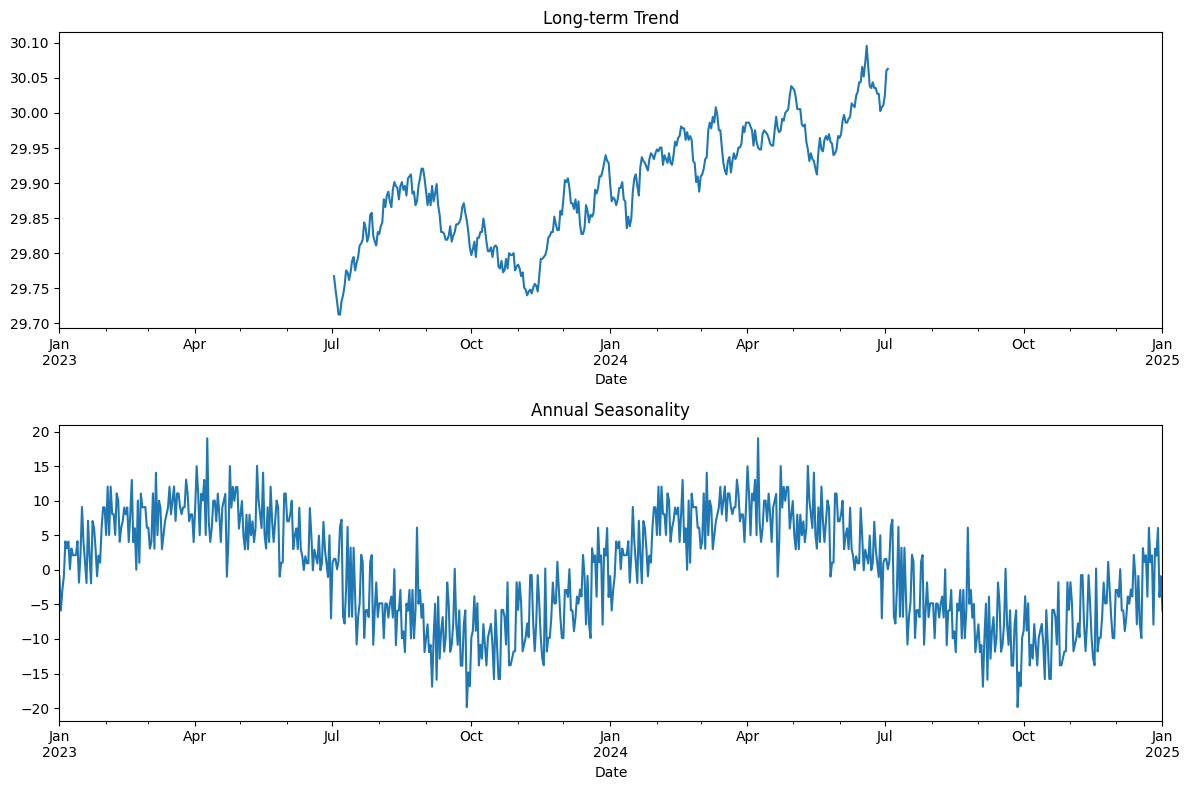

In [31]:
# Decompose the time series to see the "Seasonality" component clearly
result = seasonal_decompose(df['Patient_Count'], model='additive', period=365)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
result.trend.plot(ax=ax1, title='Long-term Trend')
result.seasonal.plot(ax=ax2, title='Annual Seasonality')
plt.tight_layout()
plt.show()

In [32]:
def create_features(df):
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['lag_7'] = df['Patient_Count'].shift(7) # What happened 1 week ago?
    df['lag_30'] = df['Patient_Count'].shift(30) # What happened 1 month ago?
    return df.dropna()

df_features = create_features(df)
X = df_features.drop('Patient_Count', axis=1)
y = df_features['Patient_Count']

# Split data (Chronological split, not random!)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training on data up to: {X_train.index.max()}")

Training on data up to: 2024-08-13 00:00:00


In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Absolute Error: {mae:.2f} patients")

Mean Absolute Error: 3.05 patients


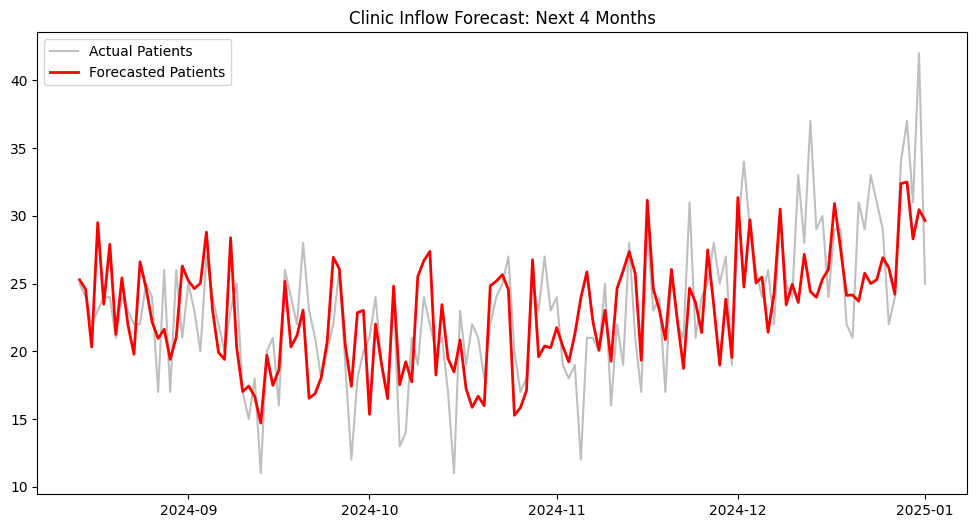

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Patients', color='gray', alpha=0.5)
plt.plot(y_test.index, predictions, label='Forecasted Patients', color='red', linewidth=2)
plt.title('Clinic Inflow Forecast: Next 4 Months')
plt.legend()
plt.show()

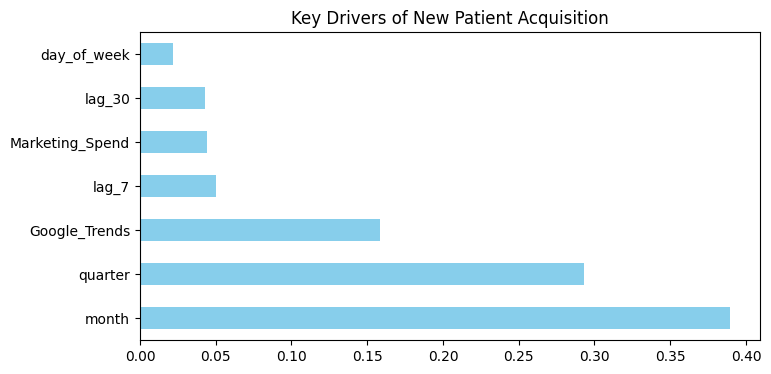

In [35]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 4))
importances.plot(kind='barh', color='skyblue')
plt.title('Key Drivers of New Patient Acquisition')
plt.show()